In [28]:
import sqlite3
import pandas as pd
connection = sqlite3.connect("Eric.db")
#connection.execute("select * from sqlite_master").fetchall() # check all available tables
query = """SELECT * 
            FROM Tweets"""
df = pd.read_sql(query,con =connection)

import warnings
warnings.simplefilter(action='ignore')

In [29]:

selection = {'#JKLive':'media','#HBDMuriuki':'media','#mainaandkingangi':'media','Jeff':'media','#staarabika':'media',
            '#GovernorNyoroPicksDG':'politics','#StepAsideRuto':'politics','Raila':'politics','Senator':'politics',
             'aaron cheruiyot':'politics',
            '#NdotoZetuUwezoWetu':'social','#SocialJusticeDay':'social','#jahmrockdoba':'social','#thursdayvibes':'social'}


In [30]:
topic = list(selection.keys())
df = df[df['Topic'].isin(topic)]
df['Topic'] = [selection[i] for i in df['Topic']]


In [31]:
df.shape
df.Topic.unique()

array(['media', 'politics', 'social'], dtype=object)

In [32]:
import nltk
from nltk.stem import WordNetLemmatizer 
from string import punctuation
lem = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
def lemmatizer(word):
    """takes a word and returns rthe root of that word eg women returns woman"""
    return lem.lemmatize(word)
def preprocess(text):
    """takes in a sentence/string removes stop words, punctuation, removes capitalizations and lemmatizes the words"""
    stop = nltk.corpus.stopwords.words('english')+ list(punctuation)+["rt","co"]
    text = text.lower()
    text = nltk.word_tokenize(text)
    clean = [i  for i in text if i not in stop]
    clean_lemmatized = [lemmatizer(i) for i in clean]
    
    return clean_lemmatized

[nltk_data] Downloading package stopwords to C:\Users\Museve
[nltk_data]     Anjeo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Museve
[nltk_data]     Anjeo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Museve
[nltk_data]     Anjeo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
# Cleaning the topics
df['Topic'] = [i[0] for i in list(map(preprocess,df.Topic))]
df['Cleaned_text'] = [i for i in list(map(preprocess,df.Text))]
df.head()

,index,Topic,User_name,Text,created_at,Cleaned_text
0,0,medium,Prince Jorum,RT @kipmurkomen: We are such a tolerant nation...,2020-02-20 09:02:13,"[kipmurkomen, tolerant, nation, watching, coll..."
1,1,medium,RAMA,"RT @citizentvkenya: ""My problem with Raila Odi...",2020-02-20 09:02:00,"[citizentvkenya, ``, problem, raila, odinga, c..."
2,2,medium,Walter Oteku,RT @kipmurkomen: We are such a tolerant nation...,2020-02-20 09:01:56,"[kipmurkomen, tolerant, nation, watching, coll..."
3,3,medium,Dush,RT @roba_eli: No heaven for the guy who went b...,2020-02-20 09:01:51,"[roba_eli, heaven, guy, went, behind, door, la..."
4,4,medium,Alikim🇰🇪,RT @kipmurkomen: We are such a tolerant nation...,2020-02-20 09:01:19,"[kipmurkomen, tolerant, nation, watching, coll..."


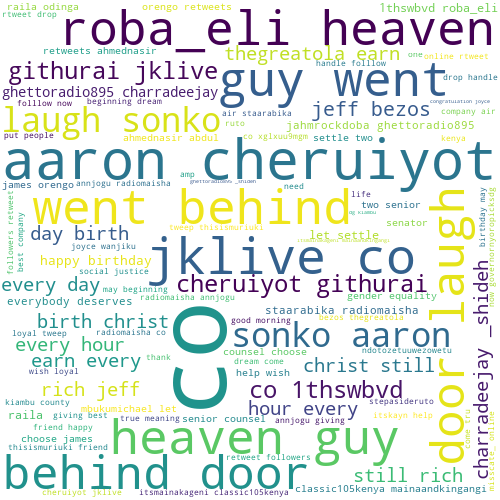

In [34]:
# Word Cloud Analysis
#!pip install WordCloud
from wordcloud import WordCloud
long  = " ".join([i for j in df.Cleaned_text for i in j])
wordcloud = WordCloud(background_color ="white",max_words =100,contour_width =3,contour_color = "steelblue",width=500,
    height=500)
wordcloud.generate(long)
wordcloud.to_image()

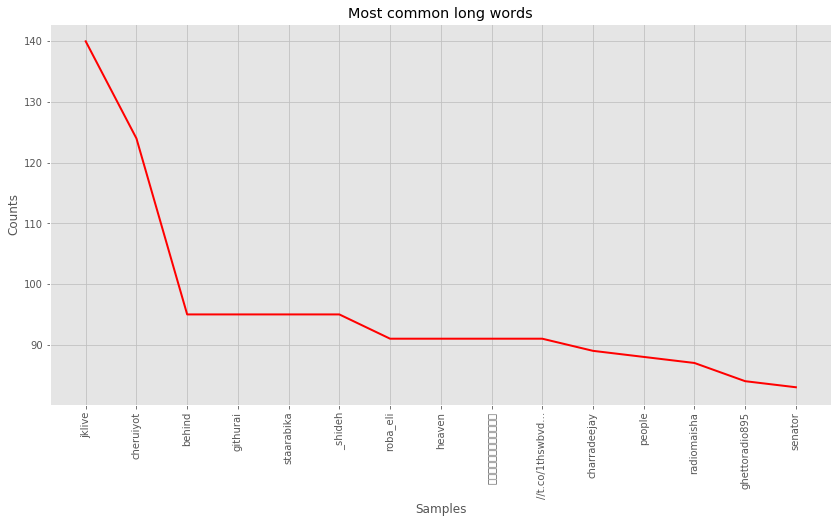

In [35]:
from collections import Counter
import matplotlib.pyplot as plt
# Analyze large words
large = [ i for i in long.split() if len(i)>5]
x = nltk.FreqDist(large)
plt.style.use('ggplot')
plt.figure(figsize = (14,7))
x.plot(15,color = 'red',title = "Most common long words")
plt.show()

In [36]:
# Machine learning Model to predict the topic
df['Cleaned_text1'] = [" ".join(i) for i in df['Cleaned_text'] ]
from sklearn.feature_extraction.text import CountVectorizer as CV
cv =CV(max_features=100)
tf = cv.fit_transform(df.Cleaned_text1)
df.head()

,index,Topic,User_name,Text,created_at,Cleaned_text,Cleaned_text1
0,0,medium,Prince Jorum,RT @kipmurkomen: We are such a tolerant nation...,2020-02-20 09:02:13,"[kipmurkomen, tolerant, nation, watching, coll...",kipmurkomen tolerant nation watching colleague...
1,1,medium,RAMA,"RT @citizentvkenya: ""My problem with Raila Odi...",2020-02-20 09:02:00,"[citizentvkenya, ``, problem, raila, odinga, c...",citizentvkenya `` problem raila odinga continu...
2,2,medium,Walter Oteku,RT @kipmurkomen: We are such a tolerant nation...,2020-02-20 09:01:56,"[kipmurkomen, tolerant, nation, watching, coll...",kipmurkomen tolerant nation watching colleague...
3,3,medium,Dush,RT @roba_eli: No heaven for the guy who went b...,2020-02-20 09:01:51,"[roba_eli, heaven, guy, went, behind, door, la...",roba_eli heaven guy went behind door laugh 🤣🤣🤣...
4,4,medium,Alikim🇰🇪,RT @kipmurkomen: We are such a tolerant nation...,2020-02-20 09:01:19,"[kipmurkomen, tolerant, nation, watching, coll...",kipmurkomen tolerant nation watching colleague...


In [37]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test =train_test_split(tf,df.Topic,random_state =1,test_size=0.3)

In [38]:
x_train.shape

(979, 100)

In [39]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
model = GBC()
model.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred = model.predict(x_test)
accuracy_score(pred,y_test)

0.8119047619047619

In [41]:
pd.DataFrame(confusion_matrix(pred,y_test),index =['medium', 'politics', 'social'],columns =['medium', 'politics', 'social'] )

,medium,politics,social
medium,117,6,1
politics,24,110,1
social,18,29,114


In [42]:
large
from collections import Counter
l=Counter(large)
x=dict(l.most_common(20))
dx=pd.DataFrame(x.keys(),columns=['Trend'])
dx['Freq']=x.values()
dx.head()

,Trend,Freq
0,jklive,140
1,cheruiyot,124
2,behind,95
3,githurai,95
4,staarabika,95


#Creating the dashboard

In [47]:
import chart_studio
import plotly_express as px 
import pandas as pd
username = 'anjeo' # your username
api_key = 'd1r3LPLqSmcfu8OL4des'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
import chart_studio.plotly as py


In [53]:
fig=px.bar(dx,x = "Trend",y ="Freq" ,title='Trending Topics In Nairobi',labels={'x':'Trends','y':'Counts'})
fig


In [54]:
py.plot(fig, filename = 'Tweet Analysis', auto_open=True)

'https://plot.ly/~anjeo/23/'